In [1]:
import ssl

ssl._create_default_https_context = ssl._create_stdlib_context

In [2]:
from pathlib import Path

import earthkit.plots
import numpy as np
import xarray as xr

In [3]:
# Retrieve the data
ERA5 = xr.open_dataset(Path() / "data" / "era5-pr" / "data.nc")

In [4]:
# Extract the data variables
# TODO: should we try different scale factors as well since they affect the float encoding?
with xr.set_options(keep_attrs=True):
    ERA5_PR = ERA5["tp"] * 1000
ERA5_PR.attrs.update(units="cm", GRIB_units="cm")

In [5]:
old_cmap_and_norm = earthkit.plots.styles.colors.cmap_and_norm

In [6]:
def my_cmap_and_norm(colors, levels, normalize=True, extend=None, extend_levels=True):
    return old_cmap_and_norm(colors, levels, normalize, extend, True)


earthkit.plots.styles.colors.cmap_and_norm = my_cmap_and_norm

In [7]:
def plot_mean_precipitation(
    my_ERA5_PR: xr.DataArray,
    cr,
    chart,
    title,
    span,
    error=False,
):
    import copy

    if error:
        err_PR = np.amax(np.abs(my_ERA5_PR - ERA5_PR))
        bias_PR = np.mean(my_ERA5_PR - ERA5_PR)

        with xr.set_options(keep_attrs=True):
            da = (my_ERA5_PR - ERA5_PR).compute()

        da.attrs.update(long_name=f"{da.long_name} error")
    else:
        da = my_ERA5_PR

    with xr.set_options(keep_attrs=True):
        da = da.mean(dim="valid_time").compute()

    da.attrs.update(long_name=f"Mean {da.long_name.lower()}")

    # compute the default style that earthkit.maps would apply
    source = earthkit.plots.sources.XarraySource(da)
    style = copy.deepcopy(
        earthkit.plots.styles.auto.guess_style(
            source,
            units=source.units,
        )
    )

    if error:
        style._levels = earthkit.plots.styles.levels.Levels(
            np.linspace(-span, span, 22)
        )
        style._legend_kwargs["ticks"] = np.linspace(-span, span, 5)
        style._colors = "coolwarm"
    else:
        style._levels = earthkit.plots.styles.levels.Levels(np.linspace(0, span, 22))
        style._legend_kwargs["ticks"] = np.linspace(0, span, 5)
        style._colors = "BuPu"

    extend_left = np.nanmin(da) < (-span if error else 0)
    extend_right = np.nanmax(da) > span

    extend = {
        (False, False): "neither",
        (True, False): "min",
        (False, True): "max",
        (True, True): "both",
    }[(extend_left, extend_right)]

    irwin_hall_error_sum_spread = np.sqrt(ERA5_PR.valid_time.size / 12)
    expected_mean_error_spread = (
        span * irwin_hall_error_sum_spread / ERA5_PR.valid_time.size
    )
    expected_mean_error_spread_2 = expected_mean_error_spread * 2  # ~95%

    with xr.set_options(keep_attrs=True):
        da_hatch = np.abs(da) > expected_mean_error_spread_2

    if error:
        style._legend_kwargs["extend"] = extend
        chart.pcolormesh(da, style=style, zorder=-11)
        chart.legend()
        chart.contourf(
            x=np.broadcast_to(da_hatch.longitude.values.reshape(1, -1), da_hatch.shape),
            y=np.broadcast_to(da_hatch.latitude.values.reshape(-1, 1), da_hatch.shape),
            z=da_hatch.values,
            colors="none",
            levels=[-0.5, 0.5, 1.5],
            hatches=[r"xx", None],
        )
    else:
        chart.quickplot(da, style=style, extend=extend, zorder=-11)
        chart.legend()

    chart.ax.set_rasterization_zorder(-10)

    if error:
        chart.title(
            f"{title}\n"
            + rf"$L_{{{{\infty}}}}(\hat{{{{PR}}}})$={err_PR:.02}  $bias(\hat{{{{PR}}}})$={bias_PR:.02}"
        )
    else:
        chart.title(f"{title}\n")

    if error:
        t = chart.ax.text(
            0.95,
            0.9,
            f"x {np.round(cr, 2)}",
            ha="right",
            va="top",
            transform=chart.ax.transAxes,
        )
        t.set_bbox(dict(facecolor="white", alpha=0.75, edgecolor="black"))

    for m in earthkit.plots.schemas.schema.quickmap_subplot_workflow:
        if m != "title":
            getattr(chart, m)()

    for m in earthkit.plots.schemas.schema.quickmap_figure_workflow:
        if m != "legend":
            getattr(chart, m)()

    counts, bins = np.histogram(
        da.values.flatten(), range=(-span if error else 0, span), bins=21
    )
    midpoints = bins[:-1] + np.diff(bins) / 2
    cb = chart.ax.collections[0].colorbar
    cax = cb.ax.inset_axes([0.0, 1.25, 1.0, 1.0])
    cax.bar(
        midpoints,
        height=counts,
        width=(bins[-1] - bins[0]) / len(counts),
        color=cb.cmap(cb.norm(midpoints)),
        edgecolor=None if error else "grey",
    )
    q1, q2, q3 = da.quantile([0.25, 0.5, 0.75]).values
    if error:
        cax.axvline(-expected_mean_error_spread_2, c="red", lw=2)
        cax.axvline(expected_mean_error_spread_2, c="red", lw=2)
    cax.axvline(da.mean().item(), ls=":", ymin=0.1, ymax=0.9, c="w", lw=2)
    cax.axvline(q1, ymin=0.25, ymax=0.75, c="w", lw=2)
    cax.axvline(q2, ymin=0.1, ymax=0.9, c="w", lw=2)
    cax.axvline(q3, ymin=0.25, ymax=0.75, c="w", lw=2)
    cax.axvline(da.mean().item(), ymin=0.1, ymax=0.9, ls=":", c="k", lw=1)
    cax.axvline(q1, ymin=0.25, ymax=0.75, c="k", lw=1)
    cax.axvline(q2, ymin=0.1, ymax=0.9, c="k", lw=1)
    cax.axvline(q3, ymin=0.25, ymax=0.75, c="k", lw=1)
    cax.set_xlim(-span if error else 0, span)
    cax.set_xticks([])
    cax.set_yticks([])
    cax.spines[:].set_visible(False)

In [8]:
eb_abs = 0.1

In [9]:
from numcodecs_combinators.stack import CodecStack
from numcodecs_safeguards import SafeguardsCodec
from numcodecs_wasm_fixed_offset_scale import FixedOffsetScale
from numcodecs_wasm_sz3 import Sz3
from numcodecs_zero import ZeroCodec

In [10]:
ERA5_PR_sg = dict()
ERA5_PR_sg_cr = dict()

for codec in [
    ZeroCodec(),
    CodecStack(
        FixedOffsetScale(offset=float(np.mean(ERA5_PR.values)), scale=1), ZeroCodec()
    ),
    Sz3(eb_mode="abs", eb_abs=eb_abs * 3),
]:
    sg = SafeguardsCodec(
        codec=codec,
        safeguards=[
            dict(kind="eb", type="abs", eb=eb_abs),
        ],
    )

    ERA5_PR_sg_enc = sg.encode(ERA5_PR.values)
    ERA5_PR_sg[codec.codec_id] = ERA5_PR.copy(data=sg.decode(ERA5_PR_sg_enc))
    ERA5_PR_sg_cr[codec.codec_id] = ERA5_PR.nbytes / np.asarray(ERA5_PR_sg_enc).nbytes

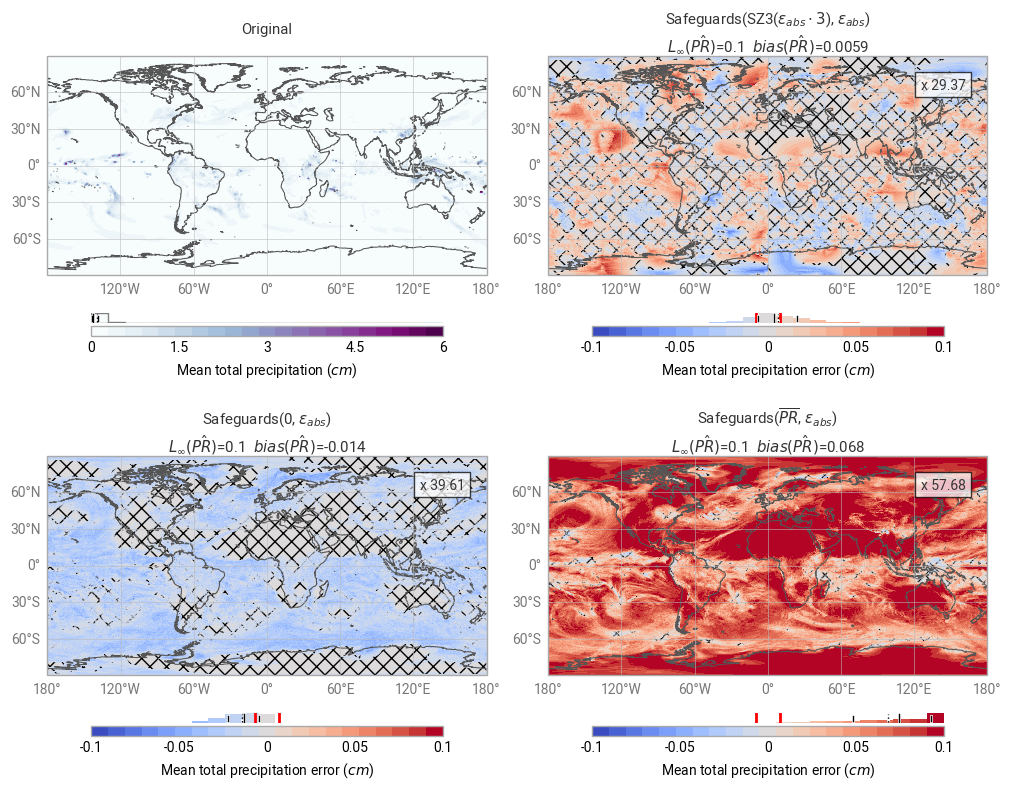

In [11]:
fig = earthkit.plots.Figure(
    size=(10, 8),
    rows=2,
    columns=2,
)

plot_mean_precipitation(ERA5_PR, 1.0, fig.add_map(0, 0), "Original", span=6)
plot_mean_precipitation(
    ERA5_PR_sg["zero"],
    ERA5_PR_sg_cr["zero"],
    fig.add_map(1, 0),
    r"Safeguards(0, $\epsilon_{{abs}}$)",
    span=eb_abs,
    error=True,
)

plot_mean_precipitation(
    ERA5_PR_sg["sz3.rs"],
    ERA5_PR_sg_cr["sz3.rs"],
    fig.add_map(0, 1),
    r"Safeguards(SZ3($\epsilon_{{abs}} \cdot 3$), $\epsilon_{{abs}}$)",
    span=eb_abs,
    error=True,
)
plot_mean_precipitation(
    ERA5_PR_sg["combinators.stack"],
    ERA5_PR_sg_cr["combinators.stack"],
    fig.add_map(1, 1),
    r"Safeguards($\overline{{PR}}$, $\epsilon_{{abs}}$)",
    span=eb_abs,
    error=True,
)

fig.save("error-distribution.pdf")